# Handling Imbalanced Dataset - Case Study

# Contents

1. Introduction
2. Problem Statement
3. Data Understanding
4. Exploratory Data Analysis
5. Feature Engineering
6. Handling Imbalanced Classes
7. Accuracy Paradox
8. Evaluation Metric
9. Conclusion

# Introduction

In a classification problem most of the times we encounter problem of class imbalance. It is very important to understand what an imbalanced dataset is and how do we handle and evaluate a classification model build on imbalanced dataset. For e.g. You are given a dataset to predict insurance claims. You have built a classification model and achieved an accuracy of ~96%.
1. Why shouldn't you be happy with your model performance?
2. What can you do about it.

# Problem Statement

One of the largest auto insurance company is facing problem of inaccuracies in car insurance claim predictions. This eventually leads them to raise the cost of insurance of good drivers and reduce it for bad drivers. The company wants you to 

- Build a model that predicts the probability that a driver will file an insurance claim in coming year

# Data Understanding

The dataset has close to 600K observations with 59 columns. This include "id" and "target" column. Therefore 57 features (inputs). Data is annonymized in order to protect the company's trade secrets, but some information about the nature of each varaible. Each row corresponds to a policy holder, and the target columns signifies that a claim was filed.

1. Values of -1 indicate that the feature was missing from the observation.
2. Target column signifies whether or not a claim was filed for that policy holder.
3. Ind is related to individual or driver
4. Reg is related to region
5. Car is related to car itself
6. Calc is a calculated feature
7. Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
8. Features without these designations are either continuous or ordinal

Okay, lets get started and look at the dataset.

In [1]:
# Importing the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in data
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


We notice that categorical features have integer values. For eg In ps_ind_02_cat we can see that values are 1, 2, 4..
Now lets check if the dataset has any duplicates.

In [3]:
df.drop_duplicates()
df.shape

(595212, 59)

No duplicates. Now lets see data types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

No null values are present because null values are replaced by -1. Also, we can see two data types - int and float. Lets see missing value status and treat them.

In [5]:
# finding missing values
missing_obs = []

for i in df.columns:
    nulls = df[df[i] == -1][i].count()
    if nulls > 0:
        missing_obs.append(i)
        nulls_perc = nulls/df.shape[0]
        
        print('{} has {} obs ({:.2%}) missing'.format(i, nulls, nulls_perc))

ps_ind_02_cat has 216 obs (0.04%) missing
ps_ind_04_cat has 83 obs (0.01%) missing
ps_ind_05_cat has 5809 obs (0.98%) missing
ps_reg_03 has 107772 obs (18.11%) missing
ps_car_01_cat has 107 obs (0.02%) missing
ps_car_02_cat has 5 obs (0.00%) missing
ps_car_03_cat has 411231 obs (69.09%) missing
ps_car_05_cat has 266551 obs (44.78%) missing
ps_car_07_cat has 11489 obs (1.93%) missing
ps_car_09_cat has 569 obs (0.10%) missing
ps_car_11 has 5 obs (0.00%) missing
ps_car_12 has 1 obs (0.00%) missing
ps_car_14 has 42620 obs (7.16%) missing


Observations on missing values: - ps_car_03_cat and ps_car_05_cat have large missing values. Therefore we will drop these variables from the dataset. Other variables we will try to impute it. So lets drop and impute. 

In [6]:
# dropping columns with high missing values
df = df.drop(columns=['ps_car_03_cat', 'ps_car_05_cat'])
df.shape

(595212, 57)

In [7]:
# Imputing with the mean or mode
from sklearn.impute import SimpleImputer
mean_imputation = SimpleImputer(missing_values=-1, strategy='mean')
mode_imputation = SimpleImputer(missing_values=-1, strategy='most_frequent')
df['ps_reg_03'] = mean_imputation.fit_transform(df[['ps_reg_03']]).ravel()
df['ps_car_12'] = mean_imputation.fit_transform(df[['ps_car_12']]).ravel()
df['ps_car_14'] = mean_imputation.fit_transform(df[['ps_car_14']]).ravel()
df['ps_car_11'] = mode_imputation.fit_transform(df[['ps_car_11']]).ravel()
df['ps_ind_02_cat'] = mode_imputation.fit_transform(df[['ps_ind_02_cat']]).ravel()
df['ps_ind_04_cat'] = mode_imputation.fit_transform(df[['ps_ind_04_cat']]).ravel()
df['ps_ind_05_cat'] = mode_imputation.fit_transform(df[['ps_ind_05_cat']]).ravel()
df['ps_car_01_cat'] = mode_imputation.fit_transform(df[['ps_car_01_cat']]).ravel()
df['ps_car_02_cat'] = mode_imputation.fit_transform(df[['ps_car_02_cat']]).ravel()
df['ps_car_07_cat'] = mode_imputation.fit_transform(df[['ps_car_07_cat']]).ravel()
df['ps_car_09_cat'] = mode_imputation.fit_transform(df[['ps_car_09_cat']]).ravel()

Cardinality of the categorical variables

We need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [8]:
# checking cardinality of categorical vars
cols_with_cardinality = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat',
                         'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat']

for i in cols_with_cardinality:
    unique_categories = df[i].value_counts().shape[0]
    print('{} has {} unique values'.format(i, unique_categories))

ps_ind_02_cat has 4 unique values
ps_ind_04_cat has 2 unique values
ps_ind_05_cat has 7 unique values
ps_car_01_cat has 12 unique values
ps_car_02_cat has 2 unique values
ps_car_04_cat has 10 unique values
ps_car_06_cat has 18 unique values
ps_car_07_cat has 2 unique values
ps_car_08_cat has 2 unique values
ps_car_09_cat has 5 unique values
ps_car_10_cat has 3 unique values
ps_car_11_cat has 104 unique values


As we can see ps_car_11_cat has 104 distinct values. Lets try to do some feature engineering and will also see how do we deal with ps_car_11_cat.

# Exploratory Data Analysis

In [9]:
df.shape

(595212, 57)

<AxesSubplot: >

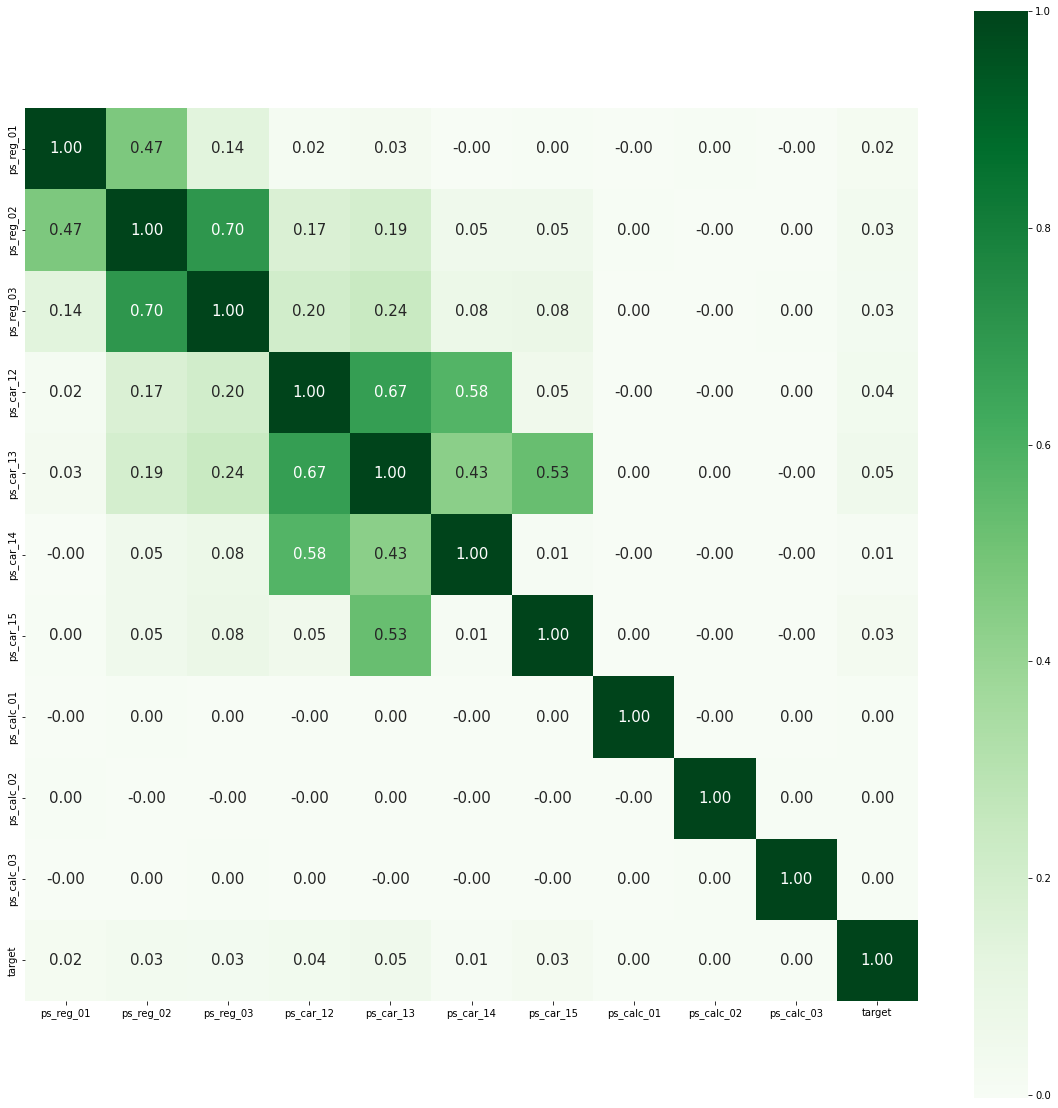

In [10]:
# check correlation of continuous vars with target
conti_cols = ['ps_reg_01','ps_reg_02','ps_reg_03','ps_car_12','ps_car_13','ps_car_14','ps_car_15','ps_calc_01','ps_calc_02',
     'ps_calc_03','target']

# Finding out the correlation between the features
conti_cols_corr = df[conti_cols].corr()

# Plotting the heatmap of correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(conti_cols_corr, cbar=True, square= True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='Greens')

There are a strong correlations between the variables ps_reg_02 and ps_reg_03, ps_car_12 and ps_car13, ps_car_12 and ps_car14 and ps_car_13 and ps_car15.

<AxesSubplot: >

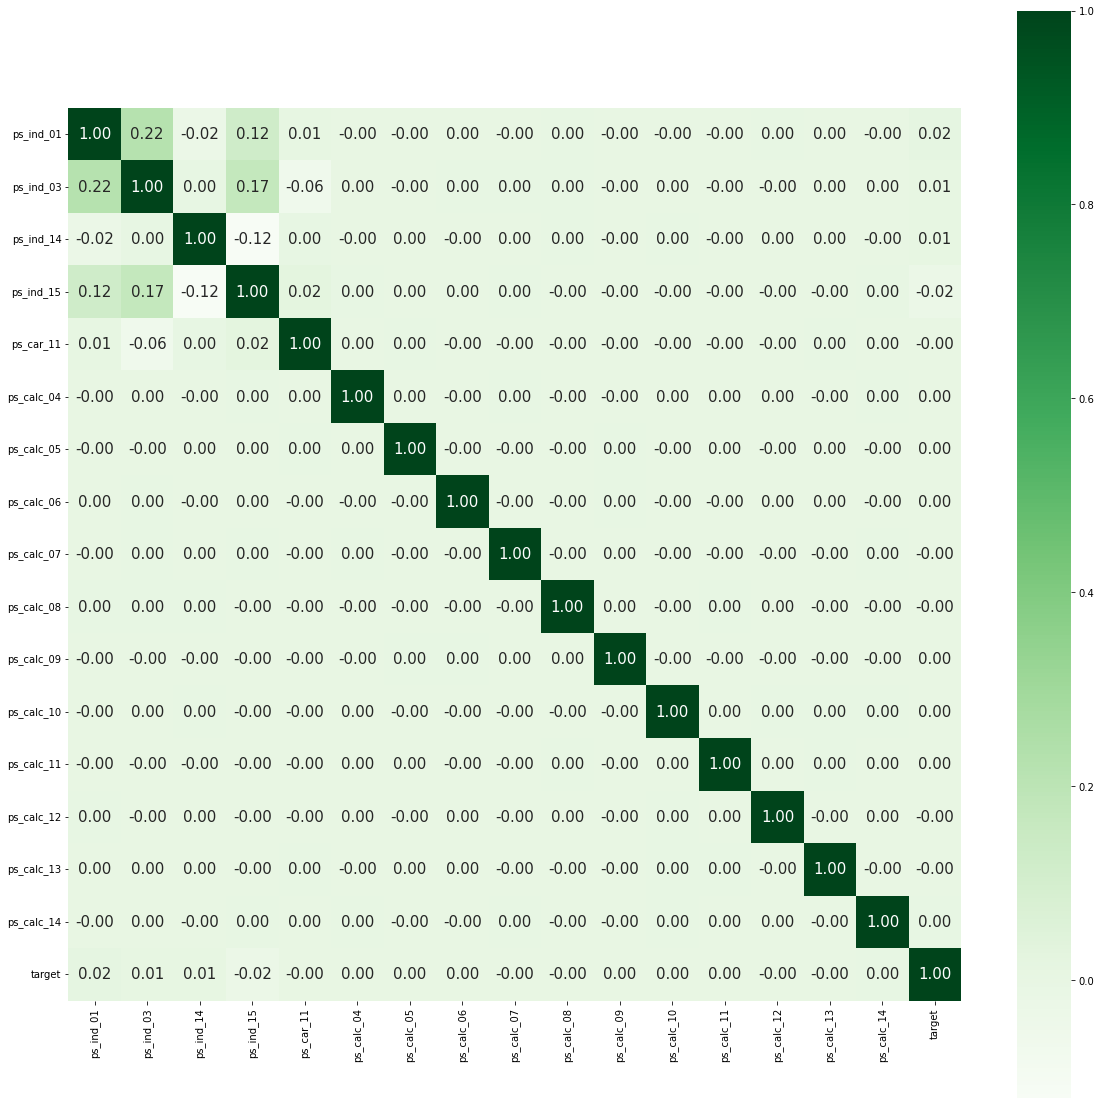

In [11]:
# check correlation of ordinal vars with target
ord_cols = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15','ps_car_11','ps_calc_04','ps_calc_05','ps_calc_06','ps_calc_07',
     'ps_calc_08','ps_calc_09','ps_calc_10','ps_calc_11','ps_calc_12','ps_calc_13','ps_calc_14','target']

# Finding out the correlation between the features
ord_cols_corr = df[ord_cols].corr()

# Plotting the heatmap of correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(ord_cols_corr, cbar=True, square= True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='Greens')

For the ordinal variables we do not see many correlations. Variables with calc has no correlations.

# Feature Engineering

We will deal with categorial features and do categorical encoding.

1. Label encoding
2. Frequency encoding
3. One-Hot encoding

1. Label encoding

Label encoding is simply converting each value in a column to a number. We can see that categorical variables in our dataset has numbers. Therefore it might already been converted to label encoding. 

For e.g. we have '0', '1', '2' representing different classes of some car related concepts like 'FWD', 'RWD', '4WD' for drive types. It is a nice way to represent information that is not in numeric format - since most ML algorthims prefer number over string. 

This does present a problem, as you can imagine, there isn't necessary a logical order to rank different drive types from 'FF' to '4DW in an ordinal manner i.e. '0','1','2'. Now that we encoding them in such a way, we have actually manually imposed such an ordinal logic which doesn't necessary exist within the observations.

Let's apply some tricks present them in a non-ordinal way, here we are going to use "frequency encoding" and "one-hot encoding"

2. Frequency encoding

The idea behind frequency encoding is to represent the levels within a categorical features with the frequency they are observe in a dataset. One of the reaons of doing this is more frequently observed level often behave in a similar way - but this is not always true.

In [12]:
# frequency encoding
cat = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat','ps_car_06_cat',
    'ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat']

df_freq = df
freq_enc = df_freq.groupby('ps_ind_02_cat').size()/len(df_freq)
df_freq.loc[:, 'ps_ind_02_cat_freq'] = df_freq['ps_ind_02_cat'].map(freq_enc)
df_freq.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_freq
0,7,0,2,2,5,1,0,0,1,0,...,1,5,8,0,1,1,0,0,1,0.207612
1,9,0,1,1,7,0,0,0,0,1,...,1,1,9,0,1,1,0,1,0,0.725918
2,13,0,5,4,9,1,0,0,0,1,...,2,7,7,0,1,1,0,1,0,0.019116
3,16,0,0,1,2,0,0,1,0,0,...,2,4,9,0,0,0,0,0,0,0.725918
4,17,0,0,2,0,1,0,1,0,0,...,1,1,3,0,0,0,1,1,0,0.207612


3. One-Hot Encoding

In this method, we map each category to a vector that contains 1 and 0 denoting the presence or absence of the feature. The number of vectors depends on the number of categories for features. This method produces a lot of columns that slows down the learning significantly if the number of the category is very high for the feature. Pandas has get_dummies function, which is quite easy to use. 

In [13]:
ohe_cols = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat','ps_car_06_cat',
    'ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat']

print('Before ohe we have {} features in train'.format(df.shape[1]))
df_ohe = pd.get_dummies(df, columns=ohe_cols, drop_first=True)
print('After ohe we have {} features in train'.format(df_ohe.shape[1]))

Before ohe we have 58 features in train
After ohe we have 205 features in train


Observations on categorical encoding:-

1. Curse of Dimensionality: - As we can see that we have lots of new features now. If we try to dig deeper we can understand that we can see that ps_car_11_cat had 104 distinct values which would make the higher number of features. For a feature with 3 levels we might be ok, but for a feature like "ps_car_11_cat" are are introducing 100+ column into a original data set with 50 columns. By doing this we more than triple the size of the dataset, and this spells trouble for machine learning due to "the curse of dimensionality".


2. Dummy Trap: - We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable. If we don't drop it we will have a problem of "DUMMY TRAP".

In [14]:
ohe_cols_new = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat','ps_car_06_cat',
    'ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat']

print('Before ohe we have {} features in train'.format(df.shape[1]))
df = pd.get_dummies(df, columns=ohe_cols_new, drop_first=True)
print('After ohe we have {} features in train'.format(df.shape[1]))

Before ohe we have 58 features in train
After ohe we have 103 features in train


In [15]:
df.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,...,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_07_cat_1,ps_car_08_cat_1,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_10_cat_1,ps_car_10_cat_2
0,7,0,2,5,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,9,0,1,7,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,0
2,13,0,5,9,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,0
3,16,0,0,2,1,0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0
4,17,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,0


# Feature Selection

As we checked correlations and cardinality of categorical variables. We will remove the vars which have no correlations and a variable which has very high cardinality of 104. We will remove ps_car_11_cat as this has 104 distinct categorical values and it will lead to sparse dataset and can arise problem of "curse of dimensionality".

In [16]:
# removing irrelevant columns
cols_to_drop = ['ps_calc_01','ps_calc_02','ps_calc_03','ps_calc_04','ps_calc_05','ps_calc_06','ps_calc_07','ps_calc_08',
                'ps_calc_09','ps_calc_10','ps_calc_11','ps_calc_12','ps_calc_13','ps_calc_14','ps_calc_15_bin',
                'ps_calc_16_bin','ps_calc_17_bin','ps_calc_18_bin','ps_calc_19_bin','ps_calc_20_bin','ps_ind_02_cat_freq',
                'ps_car_11_cat']

df.drop(cols_to_drop, inplace=True, axis=1)
df.shape

(595212, 81)

In [17]:
# splitting dataset into train and test
from sklearn.model_selection import train_test_split
y = df.target
X = df.drop('target', axis=1)
X = X.drop('id', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=56)

In [18]:
# run random forest to get feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 25).fit(X_train, y_train)

feats = X_train.columns

for feature in zip(feats, rf.feature_importances_):
    print(feature)

('ps_ind_01', 0.04973978575851322)
('ps_ind_03', 0.06472954922776282)
('ps_ind_06_bin', 0.006540080882820186)
('ps_ind_07_bin', 0.006539399722910435)
('ps_ind_08_bin', 0.006879244836686676)
('ps_ind_09_bin', 0.006605409155049496)
('ps_ind_10_bin', 0.00014080634511582925)
('ps_ind_11_bin', 0.0003505621577674994)
('ps_ind_12_bin', 0.0015465986437305519)
('ps_ind_13_bin', 0.00023063684531915492)
('ps_ind_14', 0.001953585683972142)
('ps_ind_15', 0.06698746699791845)
('ps_ind_16_bin', 0.009937911522888011)
('ps_ind_17_bin', 0.004292557375256283)
('ps_ind_18_bin', 0.008051625558796205)
('ps_reg_01', 0.05054590833169503)
('ps_reg_02', 0.061184396040451616)
('ps_reg_03', 0.10579966843990977)
('ps_car_11', 0.02125331862954584)
('ps_car_12', 0.03734686171895651)
('ps_car_13', 0.11629425659174165)
('ps_car_14', 0.07736594704579078)
('ps_car_15', 0.05091715880785103)
('ps_ind_02_cat_2', 0.012879802386525856)
('ps_ind_02_cat_3', 0.006567971034417625)
('ps_ind_02_cat_4', 0.0034624711219967364)
('ps_

In [19]:
cols_for_model = ['ps_ind_01','ps_ind_03','ps_ind_15','ps_reg_01','ps_reg_02','ps_reg_03','ps_car_11','ps_car_12','ps_car_13',
                  'ps_car_14','ps_car_15','ps_ind_02_cat_2','ps_ind_04_cat_1','ps_car_01_cat_11','ps_car_06_cat_1',
                  'ps_car_06_cat_11','ps_car_09_cat_2','target']

In [20]:
df2 = df
df = df2[cols_for_model]
df.shape

(595212, 18)

In [21]:
df.columns

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_ind_02_cat_2', 'ps_ind_04_cat_1', 'ps_car_01_cat_11',
       'ps_car_06_cat_1', 'ps_car_06_cat_11', 'ps_car_09_cat_2', 'target'],
      dtype='object')

# Handling Imbalanced Dataset

Presence of minority class in the dataset.

Lets check out our target variable.

In [22]:
print(df.target.value_counts())
df.target.value_counts(normalize = True).reset_index()

0    573518
1     21694
Name: target, dtype: int64


,index,target
0,0,0.963552
1,1,0.036448


C:\Users\aruns\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (0: No Claim || 1: Claim)')

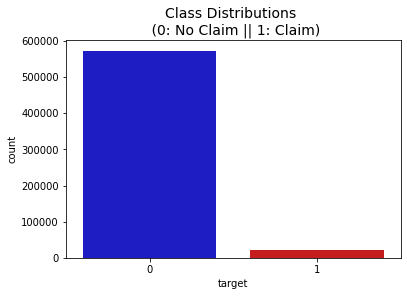

In [23]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('target', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Claim || 1: Claim)', fontsize=14)

We can see that claims that have been filed is only 3.6%. Therefore this is highly imbalanced.
Why is it important to handle imbalanced classes. 

Challenges related to imbalanced dataset
1. Biased predictions
2. Misleading accuracy

# How do we handle imbalanced class

Since we understand now that imbalanced class has to be taken care then next question is HOW?

We can handle imbalanced classes by balancing the classes by increasing minority or decreasing majority.

We can do that by following few techniques
1. Random Under-Sampling
2. Random Over-Sampling
3. SMOTE - Synthetic Minority Oversampling Technique
4. ADASYN - Adaptive Synthetic Sampling Method
5. SMOTETomek - Over-sampling followed by under-sampling

# When to Use resampling methods
# -- Use resampling methods on your training set, never on your test set!

In [24]:
# Create Train and Test Sets
from sklearn.model_selection import train_test_split
y = df.target
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=56)

In [25]:
print(y_train.value_counts())
y_train.value_counts(normalize = True).reset_index()

0    401462
1     15186
Name: target, dtype: int64


,index,target
0,0,0.963552
1,1,0.036448


In [26]:
print(y_test.value_counts())
y_test.value_counts(normalize = True).reset_index()

0    172056
1      6508
Name: target, dtype: int64


,index,target
0,0,0.963554
1,1,0.036446


In [27]:
import warnings
warnings.filterwarnings("ignore")

# Accuracy Paradox

Accuracy paradox talks about a situation where even you if you don't build a model then also your accuracy would be really high. Lets take our dataset and understand this - So we have 96% of cases where claims were not filed.

Now try to create a confusion matrix and add zeroes to predicted classes. Therefore, we have only actual numbers. Now try to calculate accuracy metric. You will still find that you have an accuracy of 96%. Lets see if we face this problem with any of our model.

# Evaluation Metric

1. Accuracy =  TN+TP / TN+FP+FN+TP


2. Precision = TP / TP+FP


3. Recall = TP / TP+FN


4. F1 Score = 2 x (precision x recall) / (precision + recall)

In this problem we will use recall as evaluation metric because we would like to capture the performace where we will be rightly predicting positive classes.

In [28]:
# Logistic Regression
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [29]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
y_pred = lreg.predict(X_test)

In [31]:
print ('Accuracy: ', accuracy_score(y_test, y_pred))
print ('F1 score: ', f1_score(y_test, y_pred))
print ('Recall: ', recall_score(y_test, y_pred))
print ('Precision: ', precision_score(y_test, y_pred))
print ('\n clasification report:\n', classification_report(y_test,y_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.9635536838332475
F1 score:  0.0
Recall:  0.0
Precision:  0.0

 clasification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    172056
           1       0.00      0.00      0.00      6508

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564


 confussion matrix:
 [[172056      0]
 [  6508      0]]


Random Under-Sampling

1. Randomly remove majority class observations
2. Help balance the dataset
3. Discarded observations could have important information
4. May lead to bias

In [32]:
# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
under_sample = RandomUnderSampler(random_state = 5)
X_resampled_us, y_resampled_us = under_sample.fit_resample(X_train, y_train)
len(X_resampled_us)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
print(sorted(Counter(y_resampled_us).items()))

In [ ]:
lreg_us = LogisticRegression()
lreg_us.fit(X_resampled_us, y_resampled_us)

y_pred_us = lreg_us.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_us))
print ('F1 score: ', f1_score(y_test, y_pred_us))
print ('Recall: ', recall_score(y_test, y_pred_us))
print ('Precision: ', precision_score(y_test, y_pred_us))
print ('\n clasification report:\n', classification_report(y_test,y_pred_us))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_us))

Tomek Links


1. Tomke link is a heuristic undersampling technique based on a distance measure. 
2. Tomek link is established based on a distance between instances from two different classes which are further used for removing majority class instance.

In [ ]:
# Tomek Links
from imblearn.under_sampling import TomekLinks
tomek_sample = TomekLinks(sampling_strategy='majority')
X_resampled_tomek, y_resampled_tomek = tomek_sample.fit_resample(X_train, y_train)
len(X_resampled_tomek)

In [ ]:
print(sorted(Counter(y_resampled_tomek).items()))

In [ ]:
lreg_tomek = LogisticRegression()
lreg_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_tomek = lreg_tomek.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_tomek))
print ('Recall: ', recall_score(y_test, y_pred_tomek))
print ('Precision: ', precision_score(y_test, y_pred_tomek))
print ('\n clasification report:\n', classification_report(y_test,y_pred_tomek))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_tomek))

Random Over-Sampling

1. Randomly add more minority observations by replication
2. No information loss
3. Prone to overfitting due to copying same information

In [ ]:
# Random OverSampling
from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)
len(X_resampled_os)

In [ ]:
print(sorted(Counter(y_resampled_os).items()))

In [ ]:
lreg_os = LogisticRegression()
lreg_os.fit(X_resampled_os, y_resampled_os)

y_pred_os = lreg_os.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_os))
print ('F1 score: ', f1_score(y_test, y_pred_os))
print ('Recall: ', recall_score(y_test, y_pred_os))
print ('Precision: ', precision_score(y_test, y_pred_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_os))

SMOTE - Synthetic Minority Oversampling Technique
Creates new "Synthetic" observations

Process: - 
1. Identify the feature vector and its nearest neighbour
2. Take the difference between the two
3. Multiply the difference with a random number between 0 and 1
4. Identify a new point on the line segment by adding the random number to feature vector
5. Repeat the process for identified feature vectors

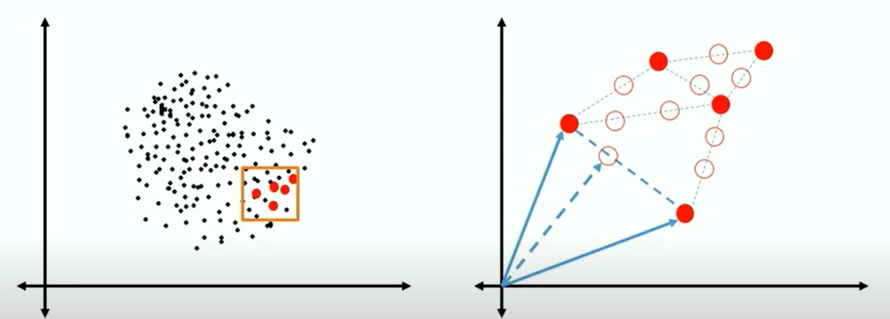

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=45, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train, y_train)
len(X_resampled_smt)

In [ ]:
print(sorted(Counter(y_resampled_smt).items()))

In [ ]:
lreg_smt = LogisticRegression()
lreg_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_smt = lreg_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_smt))
print ('F1 score: ', f1_score(y_test, y_pred_smt))
print ('Recall: ', recall_score(y_test, y_pred_smt))
print ('Precision: ', precision_score(y_test, y_pred_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_smt))

ADASYN

1. In ADASYN, the minority examples are generated based on their density distribution.
2. More synthetic data are generated from minority class samples that are harder to learn as compared with those minority samples that are easier to learn.

In [ ]:
# ADASYN
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
len(X_resampled_ada)

In [ ]:
print(sorted(Counter(y_resampled_ada).items()))

In [ ]:
lreg_ada = LogisticRegression()
lreg_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_ada = lreg_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_ada))
print ('F1 score: ', f1_score(y_test, y_pred_ada))
print ('Recall: ', recall_score(y_test, y_pred_ada))
print ('Precision: ', precision_score(y_test, y_pred_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_ada))

Combining Oversampling and Undersampling

1. Tomek links can be used as an under-sampling method or as a data cleaning method.
2. Tomek links to the over-sampled training set as a data cleaning method. Thus, instead of removing only the majority class examples that from Tomek links, examples from both classes are removed.

In [ ]:
# SMOTE+TOMEK
from imblearn.combine import SMOTETomek
smt_tmk = SMOTETomek(random_state=45)
X_resampled_smt_tmk, y_resampled_smt_tmk = smt_tmk.fit_resample(X_train, y_train)
len(X_resampled_smt_tmk)

In [ ]:
print(sorted(Counter(y_resampled_smt_tmk).items()))

In [ ]:
lreg_smt_tmk = LogisticRegression()
lreg_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_smt_tmk = lreg_smt_tmk.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_smt_tmk))
print ('\n clasification report:\n', classification_report(y_test,y_pred_smt_tmk))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_smt_tmk))

# Decision Trees

In [ ]:
# Decision Trees - Base
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc))
print ('F1 score: ', f1_score(y_test, y_pred_dtc))
print ('Recall: ', recall_score(y_test, y_pred_dtc))
print ('Precision: ', precision_score(y_test, y_pred_dtc))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc))

In [ ]:
# Decision Trees - Random UnderSampling
from sklearn.tree import DecisionTreeClassifier
dtc_us = DecisionTreeClassifier(random_state=0)
dtc_us.fit(X_resampled_us, y_resampled_us)

y_pred_dtc_us = dtc_us.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_us))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_us))
print ('Recall: ', recall_score(y_test, y_pred_dtc_us))
print ('Precision: ', precision_score(y_test, y_pred_dtc_us))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_us))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_us))

In [ ]:
# Decision Trees - Tomek Links
from sklearn.tree import DecisionTreeClassifier
dtc_tomek = DecisionTreeClassifier(random_state=0)
dtc_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_dtc_tomek = dtc_tomek.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_tomek))
print ('Recall: ', recall_score(y_test, y_pred_dtc_tomek))
print ('Precision: ', precision_score(y_test, y_pred_dtc_tomek))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_tomek))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_tomek))

In [ ]:
# Decision Trees - Random Over-Sampling
from sklearn.tree import DecisionTreeClassifier
dtc_os = DecisionTreeClassifier(random_state=0)
dtc_os.fit(X_resampled_os, y_resampled_os)

y_pred_dtc_os = dtc_os.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_os))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_os))
print ('Recall: ', recall_score(y_test, y_pred_dtc_os))
print ('Precision: ', precision_score(y_test, y_pred_dtc_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_os))

In [ ]:
# Decision Trees - SMOTE
from sklearn.tree import DecisionTreeClassifier
dtc_smt = DecisionTreeClassifier(random_state=0)
dtc_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_dtc_smt = dtc_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_smt))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_smt))
print ('Recall: ', recall_score(y_test, y_pred_dtc_smt))
print ('Precision: ', precision_score(y_test, y_pred_dtc_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_smt))

In [ ]:
# Decision Trees - ADASYN
from sklearn.tree import DecisionTreeClassifier
dtc_ada = DecisionTreeClassifier(random_state=0)
dtc_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_dtc_ada = dtc_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_ada))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_ada))
print ('Recall: ', recall_score(y_test, y_pred_dtc_ada))
print ('Precision: ', precision_score(y_test, y_pred_dtc_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_ada))

In [ ]:
# Decision Trees - SMOTE+TOMEK
from sklearn.tree import DecisionTreeClassifier
dtc_smt_tmk = DecisionTreeClassifier(random_state=0)
dtc_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_dtc_smt_tmk = dtc_smt_tmk.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_dtc_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_dtc_smt_tmk))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_smt_tmk))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_smt_tmk))

# Random Forest

In [ ]:
# Random Forest - Base
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print ('F1 score: ', f1_score(y_test, y_pred_rf))
print ('Recall: ', recall_score(y_test, y_pred_rf))
print ('Precision: ', precision_score(y_test, y_pred_rf))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf))

In [ ]:
# Random Forest - Random UnderSampling
rf_us = RandomForestClassifier()
rf_us.fit(X_resampled_us, y_resampled_us)

y_pred_rf_us = rf_us.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_us))
print ('F1 score: ', f1_score(y_test, y_pred_rf_us))
print ('Recall: ', recall_score(y_test, y_pred_rf_us))
print ('Precision: ', precision_score(y_test, y_pred_rf_us))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_us))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_us))

In [ ]:
# Random Forest - Tomek Links
rf_tomek = RandomForestClassifier()
rf_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_rf_tomek = rf_tomek.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_rf_tomek))
print ('Recall: ', recall_score(y_test, y_pred_rf_tomek))
print ('Precision: ', precision_score(y_test, y_pred_rf_tomek))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_tomek))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_tomek))

In [ ]:
# Random Forest - Random Over-Sampling
rf_os = RandomForestClassifier()
rf_os.fit(X_resampled_os, y_resampled_os)

y_pred_rf_os = rf_os.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_os))
print ('F1 score: ', f1_score(y_test, y_pred_rf_os))
print ('Recall: ', recall_score(y_test, y_pred_rf_os))
print ('Precision: ', precision_score(y_test, y_pred_rf_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_os))

In [ ]:
# Random Forest - SMOTE
rf_smt = RandomForestClassifier()
rf_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_rf_smt = rf_smt.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_smt))
print ('F1 score: ', f1_score(y_test, y_pred_rf_smt))
print ('Recall: ', recall_score(y_test, y_pred_rf_smt))
print ('Precision: ', precision_score(y_test, y_pred_rf_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_smt))

In [ ]:
# Random Forest - ADASYN
rf_ada = RandomForestClassifier()
rf_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_rf_ada = rf_ada.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_ada))
print ('F1 score: ', f1_score(y_test, y_pred_rf_ada))
print ('Recall: ', recall_score(y_test, y_pred_rf_ada))
print ('Precision: ', precision_score(y_test, y_pred_rf_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_ada))

In [ ]:
# Random Forest - SMOTE+TOMEK
rf_smt_tmk = RandomForestClassifier()
rf_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_rf_smt_tmk = rf_smt_tmk.predict(X_test)

In [ ]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_rf_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_rf_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_rf_smt_tmk))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_smt_tmk))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_smt_tmk))

So we ran three different algorithm with various techniques to handle imbalanced classes. Lets compare the results now. 

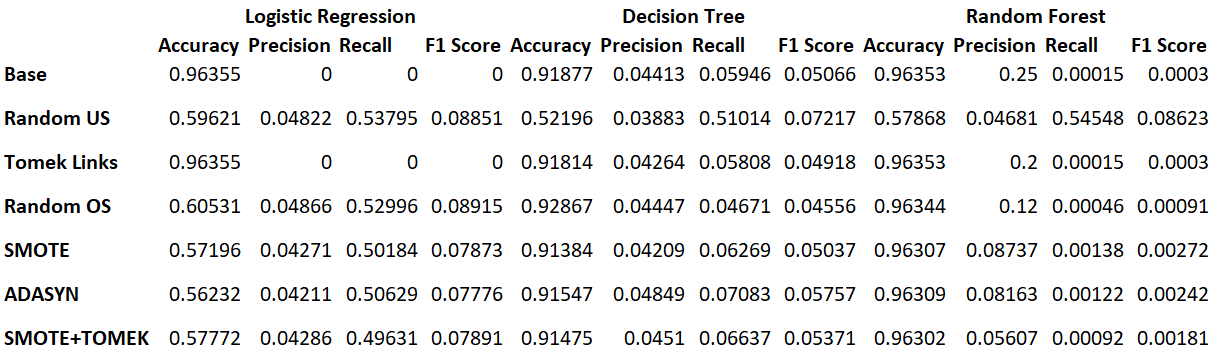

As we can see above on the summary table, we have recall value highest for Random Forest with random undersampling. We can also notice that recall values of logistic regression for both under and oversamplings are closer to each other. Within logistic regression random undersampling has highest recall. 


So we will pick up random forest with undersampling method as best performing model. 


As a next step we do need to further fine tune the model by working on to optimize hyperparameters using grid search/ randomized search. Also, we need to do a 5 or 10 fold cross validation on the training set before finalizing the model.

# Conclusion

Its very important to understand that there is no single methodology which suits all problems.


1. As we can see, there are some cases where undersampling methods are performing better than oversampling methods, and in some, oversampling mehtods are performing better than undersampling, but its also important to use multiple methods for feature engineering of the data and then compare results for selecting the best possible method.
2. As undersampling methods removes majority class from data - It can be an issue in many cases as we might lose significant information.
3. Also, the use of over-sampling methods generates samples from data - It can result in creating irrelevant observations and can also result in overfitting.
4. Interpreting and understaning the evaluation metric is important and how these can be used to help solve a business problem in the real world.
5. Model evaluation - Do not use accuracy score as a metric. In a dataset with 96% non-claim observations, you will likely make correct prediction 96% of time. Confusion matrix and precision/recall score are better metric.